# Demonstration with Reuters Datasets

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install git+https://github.com/Julien2048/NLP_Project_OOD.git
!git clone https://github.com/Julien2048/NLP_Project_OOD
!pip install -r NLP_Project_OOD/requirements.txt

In [4]:
%cd gdrive/MyDrive/NLP_Project_OOD/distilbert
!rm /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py
!cp modeling_distilbert.py /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/

!rm /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/__init__.py
!cp __init__.py /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/
%cd ..

%cd transformers
!rm /usr/local/lib/python3.8/dist-packages/transformers/__init__.py
!cp __init__.py /usr/local/lib/python3.8/dist-packages/transformers/
%cd ..
%cd ..
%cd ..
%cd ..

/content/gdrive/MyDrive/NLP_Project_OOD/distilbert
/content/gdrive/MyDrive/NLP_Project_OOD
/content/gdrive/MyDrive/NLP_Project_OOD/transformers
/content/gdrive/MyDrive/NLP_Project_OOD
/content/gdrive/MyDrive
/content/gdrive
/content


In [2]:
import keras
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassificationPreLogits
from transformers import Trainer, TrainingArguments
import torch

In [3]:
from nlp_project.data_loader import ReutersDataset, CreateDataset
from nlp_project.OOD_detector import Mahalanobis
from nlp_project.metrics import ResultsOOD
from nlp_project.BERT_adaptation import TokenizeData, DistilBertClassifier

## Load Reuters Datasets

### Download Reuters Data

In [4]:
get_reuters = ReutersDataset()
reuters_in_train_texts, reuters_in_test_texts, reuters_out_test_texts, reuters_in_train_labels, reuters_in_test_labels, reuters_out_test_labels = get_reuters.get_dataset()
get_reuters.save_labels()
get_reuters.save_texts()

### Load Reuters Datasets

In [ ]:
get_reuters = ReutersDataset()
reuters_in_train_texts, reuters_in_test_texts, reuters_out_test_texts = get_reuters.load_texts()
reuters_in_train_labels, reuters_in_test_labels, reuters_out_test_labels = get_reuters.load_labels()

In [5]:
print("Len Reuters In Train Dataset: ", len(reuters_in_train_labels))
print("Len Reuters In Test Dataset: ", len(reuters_in_test_labels))
print("Len Reuters Out Test Dataset: ", len(reuters_out_test_labels))

Len Reuters In Train Dataset:  8763
Len Reuters In Test Dataset:  5833
Len Reuters Out Test Dataset:  1699


## Prelogits extraction

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Tokenize data

In [7]:
NB_TEXTS_TRAIN = None
NB_TEXTS_TEST = 1600

#### Create tokens

In [ ]:
tokenizer = TokenizeData()
reuters_in_input_ids_train, reuters_in_attention_masks_train = tokenizer(reuters_in_train_texts, "reuters_in", "train", NB_TEXTS_TRAIN)
tokenizer.save_tokens()

reuters_in_input_ids_test, reuters_in_attention_masks_test = tokenizer(reuters_in_test_texts, "reuters_in", "test", NB_TEXTS_TEST)
tokenizer.save_tokens()

reuters_out_input_ids_test, reuters_out_review_attention_masks_test = tokenizer(reuters_out_test_texts, "reuters_out", "test", NB_TEXTS_TEST)
tokenizer.save_tokens()

#### Load Tokens

In [ ]:
tokenizer = TokenizeData(model=None)
reuters_in_input_ids_train, reuters_in_attention_masks_train = tokenizer.load_tokens("reuters_in", "train")
reuters_in_input_ids_test, reuters_in_attention_masks_test  = tokenizer.load_tokens("reuters_in", "test")

reuters_out_input_ids_test, reuters_out_attention_masks_test = tokenizer.load_tokens("reuters_out", "test")

### Train the model

In [9]:
# Create the train, validation and test sets
reuters_in_encodings_train = {'input_ids':reuters_in_input_ids_train,
                      'attention_mask':reuters_in_attention_masks_train}
reuters_in_encodings_test = {'input_ids':reuters_in_input_ids_test,
                      'attention_mask':reuters_in_attention_masks_test}

reuters_in_train_dataset = CreateDataset(reuters_in_encodings_train, reuters_in_train_labels)
reuters_in_test_dataset = CreateDataset(reuters_in_encodings_test, reuters_in_test_labels[:NB_TEXTS_TEST])

In [10]:
# CONSTANTS
BATCH_SIZE = 32
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
LEARNING_RATE = 1e-5
NUM_EPOCHS = 3
LOG_STEPS = 100

#### Train Classifier

In [11]:
model = DistilBertClassifier(device=device, training=True, num_epochs=4, num_labels=15)
model.train_model(reuters_in_train_dataset, reuters_in_test_dataset)
model.save_pretrained_model("distilbert_reuters")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassificationPreLogits: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassificationPreLogits from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassificationPreLogits from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassificationPreLogits were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 

Step,Training Loss
100,2.591000
200,1.817700
300,1.244900
400,0.915500
500,0.763300
600,0.660900
700,0.571100
800,0.510000
900,0.492900
1000,0.451100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/nlp_project/data_loader.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/nlp_project/data_loader.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(v

#### Load Classifier

In [13]:
DistilBertClassifier(
    device=device,
    path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_reuters_distilbert/",
    num_labels=15
    )

### Get Logits and Prelogits 

In [34]:
reuters_in_prelogits_train, reuters_in_logits_train = model.get_prelogit_logit(reuters_in_input_ids_train.to(device), reuters_in_attention_masks_train.to(device), "reuters_in", "train", save=True)
reuters_in_prelogits_test, reuters_in_logits_test = model.get_prelogit_logit(reuters_in_input_ids_test.to(device), reuters_in_attention_masks_test.to(device), "reuters_in", "test", save=True)

reuters_out_prelogits_test, reuters_out_logits_test = model.get_prelogit_logit(reuters_out_input_ids_test.to(device), reuters_out_review_attention_masks_test.to(device), "reuters_out", "test", save=True)

## Computing OOD
### Mahalanobis Score

In [35]:
maha_reuters = Mahalanobis(
    reuters_in_prelogits_train,
    reuters_in_prelogits_test,
    reuters_out_prelogits_test,
    reuters_in_train_labels,
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_reuters, scores_reuters = maha_reuters()

Average value of cov_inv matrix : 143954603.596528
Average distance between cov_inv*cov and identity matrix : 0.0018202899323015566


AUROC : 43.23 %


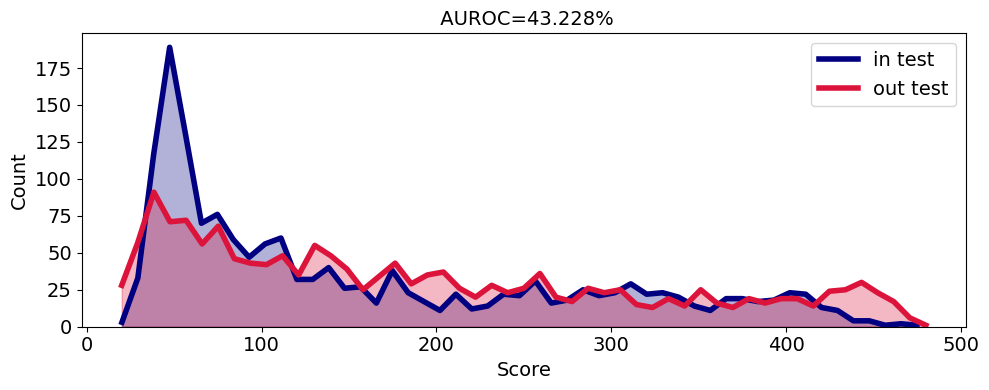

In [36]:
results_reuters = ResultsOOD(onehots_reuters, scores_reuters)
results_reuters()

### Maximum Softmax

In [37]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

AUROC : 61.14 %


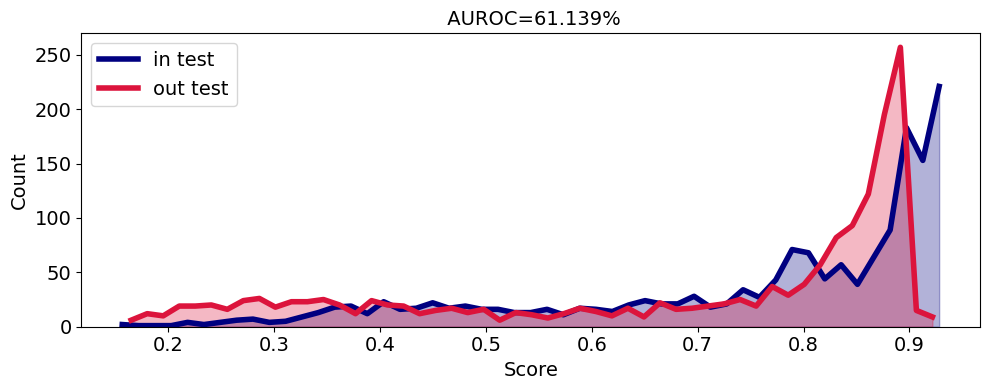

In [38]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(reuters_in_logits_test),axis=-1),
     np.max(np_softmax(reuters_out_logits_test),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(reuters_in_logits_test)+[0]*len(reuters_out_logits_test)
)

results = ResultsOOD(onehots, scores)
results()